In [1]:
# %pip install pmdarima statsmodels

In [2]:
# import libary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict Gold Price/XAU_1d_data.csv', sep=';')

df.columns = df.columns.str.lower()

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print(df.head())
print(f"Null:\n{df.isna().sum()}")


             open   high    low  close  volume
date                                          
2004-06-11  384.0  384.8  382.8  384.1     272
2004-06-14  384.3  385.8  381.8  382.8    1902
2004-06-15  382.8  388.8  381.1  388.6    1951
2004-06-16  387.1  389.8  382.6  383.8    2014
2004-06-17  383.6  389.3  383.0  387.6    1568
Null:
open      0
high      0
low       0
close     0
volume    0
dtype: int64


###  TIME SERIES ANALYSIS – TREND | SEASONALITY | CYCLE | VARIATION

In [ ]:
#Close and Volume on two y-axes
plt.figure(figsize=(18,5))

# Create the first y-axis for the close price
ax1 = plt.gca()
ax1.plot(df.index, df['close'], label='close', color='dodgerblue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')
ax1.tick_params(axis='y', labelcolor='dodgerblue') # Match tick color to line color

# Create the second y-axis for the volume
ax2 = ax1.twinx() # Create a twin Axes sharing the x-axis
ax2.plot(df.index, df['volume'], label='Volume', color='blue', alpha=0.2)
ax2.set_ylabel('Volume')
ax2.tick_params(axis='y', labelcolor='blue') # Match tick color to line color

plt.title('XAUUSD Trading Close Price and Volume Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Augmented Dickey-Fuller (ADF) test to formally check this.
- Null Hypothesis ($H_0$): The time series is non-stationary (it has a unit root).
- Alternative Hypothesis ($H_1$​): The time series is stationary.

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Performs and prints the results of the ADF test."""
    print("--- Results of Augmented Dickey-Fuller Test ---")
    result = adfuller(series.dropna())

    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")

    if result[1] <= 0.05:
        print("Conclusion: Reject H0. The series is likely stationary.")
    else:
        print("Conclusion: Fail to Reject H0. The series is non-stationary.")

# Run the test on the 'close' price
adf_test(df['close'])

--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: 1.2942
p-value: 0.9966
Conclusion: Fail to Reject H0. The series is non-stationary.


<Figure size 1400x1000 with 0 Axes>

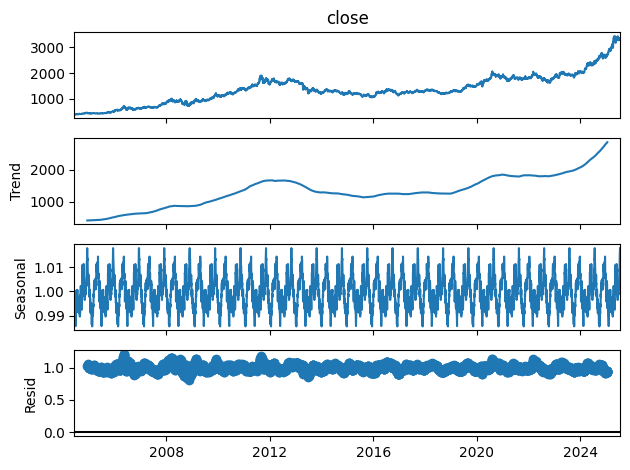

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'close' price series (using the Multiplicative model)
# We assume a periodicity of 252 (number of trading days in a year)
decomposition = seasonal_decompose(df['close'], model='multiplicative', period=252)

# Plot the decomposed components
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

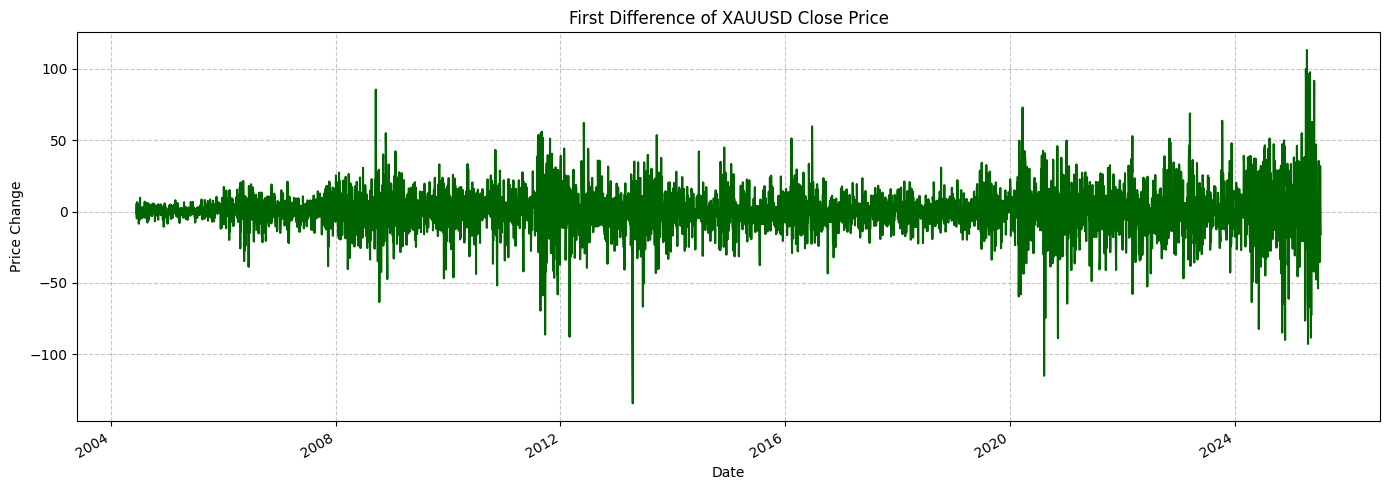


--- Testing Stationarity of the DIFFERENCED Series ---
--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: -73.5702
p-value: 0.0000
Conclusion: Reject H0. The series is likely stationary.


In [8]:
# Calculate the first difference of the close price
df['close_diff'] = df['close'].diff(periods=1)

# Plot the differenced series
plt.figure(figsize=(14, 5))
df['close_diff'].plot(title='First Difference of XAUUSD Close Price',
                      color='darkgreen',
                      linewidth=1.5)
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Test the differenced series for stationarity
print("\n--- Testing Stationarity of the DIFFERENCED Series ---")
adf_test(df['close_diff'])

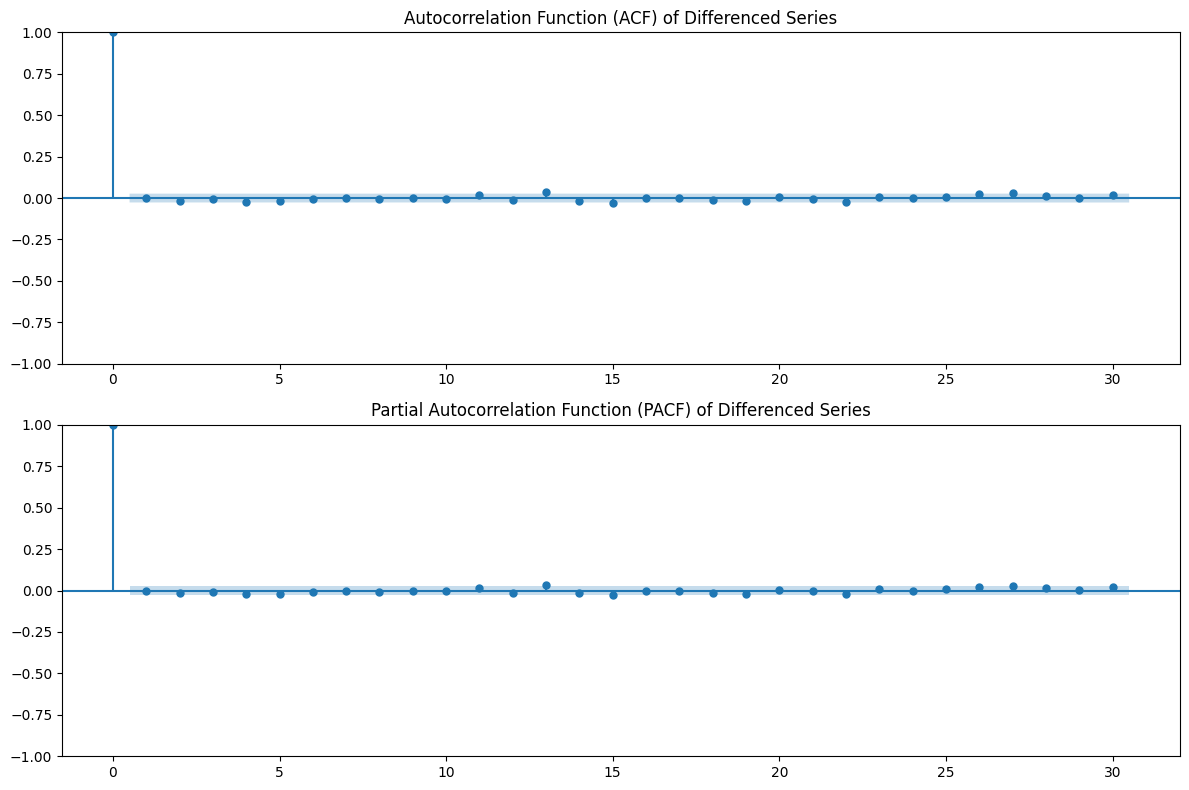

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure you use the stationary series (the first difference)
stationary_series = df['close_diff'].dropna()

# Create plots for ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelation Function (ACF) plot
plot_acf(stationary_series, lags=30, ax=axes[0], title='Autocorrelation Function (ACF) of Differenced Series')

# Partial Autocorrelation Function (PACF) plot
plot_pacf(stationary_series, lags=30, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Differenced Series')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 5418
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -22458.646
Date:                Mon, 27 Oct 2025   AIC                          44923.292
Time:                        02:13:54   BIC                          44943.084
Sample:                             0   HQIC                         44930.200
                               - 5418                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8508      0.100      8.548      0.000       0.656       1.046
ma.L1         -0.8622      0.096     -9.003      0.000      -1.050      -0.674
sigma2       233.6990      2.068    112.980      0.0

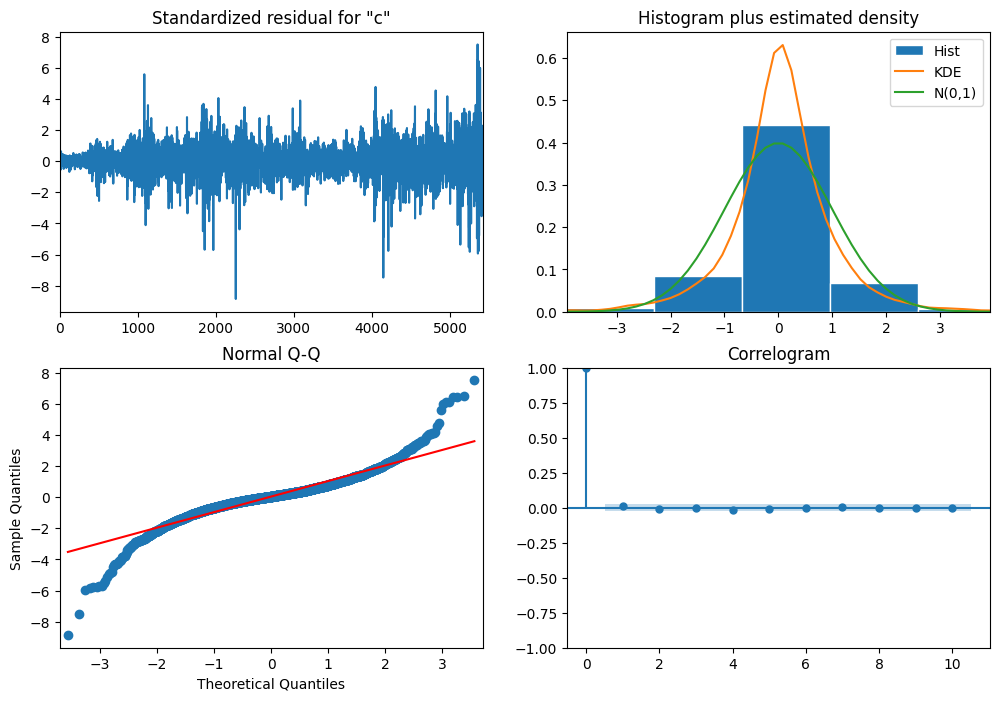

In [10]:
# ASSUMING you found p=1 and q=1 from the plots, for example:
p, d, q = 1, 1, 1

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['close'], order=(p, d, q))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()

Based on the time series analysis:
* The XAUUSD close price series was found to be non-stationary, as indicated by the Augmented Dickey-Fuller (ADF) test (p-value > 0.05).
* Differencing the series once made it stationary (ADF test p-value < 0.05).
* The ACF and PACF plots of the differenced series helped in identifying potential orders for ARIMA models (though an LSTM was used in this case).

The LSTM model was built and trained to predict the close price.
* The model achieved a Mean Squared Error (MSE) of {mse:.4f} and a Root Mean Squared Error (RMSE) of {rmse:.4f} on the test data.
* The plot of actual vs. predicted values shows the model's ability to capture the general trend of the price movements, although there are deviations between the predicted and actual values.

Further steps could involve:
* Hyperparameter tuning for the LSTM model to potentially improve performance.
* Exploring other time series forecasting models (e.g., ARIMA, Prophet, other deep learning architectures).
* Incorporating additional features (e.g., other technical indicators, news sentiment) to potentially enhance prediction accuracy.